##  initial selection on galaxies: 1 measurements within 1 effective radius

0it [00:00, ?it/s]

346 galaxies with profile
346
['9.28+-0.30', '9.97+-0.19', '10.67+-0.31']
['0.98+-0.13', '1.26+-0.12', 'nan+-nan']


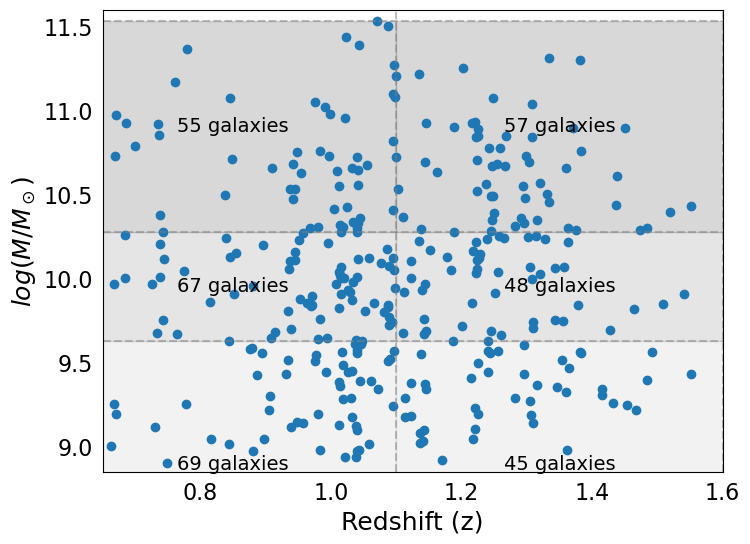

In [ ]:
from   astropy.io import fits
import numpy as np
from   astropy.table import Table
from   tqdm.auto import tqdm
import matplotlib.pyplot as plt
from   scripts.tools    import *
from   scripts.hst3d      import *
from   scripts.jwst       import *
import os
import time
#for plotting I set a series colorblind safe colors in hexcode
color1 = '#1b9e77'
color2 = '#d95f02'
color3 = '#7570b3'

obj_lis = Table.read('obj_lis_selected.fits')

#obj_lis = obj_lis[obj_lis['manual_select'] == 'keep']
obj_lis_with_profile = []
has_profile = np.zeros(len(obj_lis))

for i, obj in tqdm(enumerate(obj_lis)):
    path = f"data_extracted/{file_name(obj, prefix='extracted')}"
    try:
        with fits.open(path) as hdu:
            data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
            r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
            mask_r = (r < 1*obj['re']/0.1*obj['pixel_length'])
            mask_limit = (ha_r > ha_lim) & (hb_r > hb_lim)
            if len(r[mask_r & mask_limit]) > 0:
                has_profile[i] = 1
    except Exception as e:
            has_profile[i] = 0
obj_lis['has_profile'] = has_profile

obj_lis = obj_lis[obj_lis['has_profile'] == 1]
obj_lis.write('obj_lis_prof.fits', overwrite=True)
print(len(obj_lis), 'galaxies with profile')



# Create mass bins with equal number of galaxies m   
sorted_masses = np.sort(np.log10(obj_lis['mass']))
bins_m = [sorted_masses[0], sorted_masses[len(sorted_masses) // 3], sorted_masses[2 * len(sorted_masses) // 3], sorted_masses[-1]]

# Create labels for the mass bins
bin_label_m = [f'{bins_m[i]:.2f}<logm<{bins_m[i+1]:.2f}' for i in range(len(bins_m) - 1)]
binning_m = np.digitize(np.log10(obj_lis['mass']),bins_m)

bins_z  = [-np.inf,1.1,np.inf]
binning_z = np.digitize(obj_lis['z_MAP'],bins_z)
bin_label_m = [r'$8.9<logM/M_\odot<9.8$',r'$9.8<logM/M_\odot<10.35$',r'$10.35<logM/M_\odot<11.5$']
bin_label_z = ['0.7<z<1.1','1.1<z<1.5']

obj_lis['bin_m'] = binning_m
obj_lis['bin_z'] = binning_z
obj_lis.write('obj_lis_selected_bins.fits',overwrite=True)


def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

print(len(obj_lis))

binning_m_sel = binning_m
binning_z_sel = binning_z
std_lis = [np.log10(np.median(obj_lis['mass'][binning_m==i])) for i in range(1,4)]
std_lis_var = [np.std(np.log10(obj_lis['mass'][binning_m==i])) for i in range(1,4)]
print([f'{std_lis[i]:.2f}+-{std_lis_var[i]:.2f}' for i in range(3)])


#check the properties for mass and 
std_lis = [np.median(obj_lis['z_MAP'][binning_z==i]) for i in range(1,4)]
std_lis_var = [np.std(obj_lis['z_MAP'][binning_z==i]) for i in range(1,4)]
print([f'{std_lis[i]:.2f}+-{std_lis_var[i]:.2f}' for i in range(3)])

# Define the bin edges for mass and redshift
mass_bins = bins_m
redshift_bins = [0.6, 1.1, 1.6]

fit = plt.figure(figsize=(8, 6))
# Plot the data points
plt.plot(obj_lis['z_MAP'], np.log10(obj_lis['mass']), 'o')

# Add vertical lines for redshift bins
for z in redshift_bins:
    plt.axvline(z, color='grey', linestyle='--', alpha=0.5)

# Add horizontal lines for mass bins
for m in mass_bins:
    plt.axhline(m, color='grey', linestyle='--', alpha=0.5)

# Add shaded regions for each bin and annotate the number of data points
for i in range(len(redshift_bins) - 1):
    for j in range(len(mass_bins) - 1):
        bin_mask = (obj_lis['z_MAP'] >= redshift_bins[i]) & (obj_lis['z_MAP'] < redshift_bins[i + 1]) & (np.log10(obj_lis['mass']) >= mass_bins[j]) & (np.log10(obj_lis['mass']) < mass_bins[j + 1])
        num_points = np.sum(bin_mask)
        plt.fill_betweenx([mass_bins[j], mass_bins[j + 1]], redshift_bins[i], redshift_bins[i + 1], color='grey', alpha=0.1 * (j + 1))
        plt.text((redshift_bins[i] + redshift_bins[i + 1]) / 2, (mass_bins[j] + mass_bins[j + 1]) / 2, f'{num_points} galaxies', color='black', ha='center', va='center', fontsize=14)
#display no tick lines in the plot
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=True, labelleft=True)
#make x,y axis lablel big
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(8.85, 11.6)
plt.xlim(0.65, 1.6)
plt.xlabel('Redshift (z)', fontsize=18)
plt.ylabel(r'$log(M/M_\odot)$', fontsize=18)
#plt.savefig('image_outputs/mass_redshift_bins.png')
plt.show()


## manual selection 

In [ ]:
import os
import glob
import warnings
import pickle
from astropy.table import Table
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
from ipywidgets import Button, VBox, HBox, Label, Output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 抑制警告
warnings.filterwarnings('ignore')

# 读取对象列表
obj_lis = Table.read('obj_lis_selected_bins.fits')

# 历史选择记录文件路径
HISTORY_FILE = 'manual_selection_history.pkl'

def load_selection_history():
    """加载历史选择记录"""
    if os.path.exists(HISTORY_FILE):
        try:
            with open(HISTORY_FILE, 'rb') as f:
                return pickle.load(f)
        except:
            print("警告: 无法加载历史选择记录，将创建新的记录文件")
            return {}
    return {}

def save_selection_history(decisions):
    """保存选择历史到文件"""
    try:
        with open(HISTORY_FILE, 'wb') as f:
            pickle.dump(decisions, f)
    except Exception as e:
        print(f"保存选择历史失败: {e}")

class ManualSelector:
    def __init__(self, obj_list):
        self.obj_list = obj_list
        self.current_index = 0
        
        # 加载历史选择记录
        self.all_decisions = load_selection_history()
        
        # 从历史记录中预填充当前对象列表的决定
        self.decisions = {}
        undecided_count = 0
        decided_count = 0
        
        for obj in self.obj_list:
            obj_id = f"{obj['subfield']}-{obj['ID']}"
            if obj_id in self.all_decisions:
                self.decisions[obj_id] = self.all_decisions[obj_id]
                decided_count += 1
            else:
                undecided_count += 1
        
        print(f"历史记录加载完成:")
        print(f"- 已有决定的对象: {decided_count}")
        print(f"- 未决定的对象: {undecided_count}")
        print(f"- 总历史记录数: {len(self.all_decisions)}")
        
        self.output = Output()
        
        # 创建UI组件
        self.image_output = Output()
        self.info_label = Label(value="")
        self.keep_button = Button(description="保留 (Keep)", button_style='success')
        self.remove_button = Button(description="去除 (Remove)", button_style='danger')
        self.prev_button = Button(description="上一个 (Previous)", button_style='info')
        self.next_button = Button(description="下一个 (Next)", button_style='info')
        self.skip_decided_button = Button(description="跳到未决定", button_style='warning')
        self.save_button = Button(description="保存结果 (Save Results)", button_style='primary')
        
        # 绑定按钮事件
        self.keep_button.on_click(self.on_keep_clicked)
        self.remove_button.on_click(self.on_remove_clicked)
        self.prev_button.on_click(self.on_prev_clicked)
        self.next_button.on_click(self.on_next_clicked)
        self.skip_decided_button.on_click(self.on_skip_decided_clicked)
        self.save_button.on_click(self.on_save_clicked)
        
        # 创建界面布局
        button_row1 = HBox([self.prev_button, self.next_button, self.skip_decided_button])
        button_row2 = HBox([self.keep_button, self.remove_button])
        self.ui = VBox([
            self.info_label,
            self.image_output,
            button_row1,
            button_row2,
            self.save_button,
            self.output
        ])
        
        # 如果有未决定的对象，跳到第一个未决定的对象
        if undecided_count > 0:
            self.skip_to_next_undecided(from_start=True)
        else:
            self.show_current_object()
    
    def skip_to_next_undecided(self, from_start=False):
        """跳到下一个未决定的对象"""
        start_index = 0 if from_start else self.current_index + 1
        
        for i in range(start_index, len(self.obj_list)):
            obj = self.obj_list[i]
            obj_id = f"{obj['subfield']}-{obj['ID']}"
            if obj_id not in self.decisions:
                self.current_index = i
                self.show_current_object()
                return
        
        # 如果没找到未决定的对象，从头开始找
        if not from_start:
            for i in range(0, self.current_index):
                obj = self.obj_list[i]
                obj_id = f"{obj['subfield']}-{obj['ID']}"
                if obj_id not in self.decisions:
                    self.current_index = i
                    self.show_current_object()
                    return
        
        # 所有对象都已决定
        with self.output:
            clear_output()
            print("所有对象都已经做过决定!")
        
    def on_skip_decided_clicked(self, button):
        """点击跳到未决定按钮"""
        self.skip_to_next_undecided()
        
    def get_image_path(self, obj):
        """根据对象属性找到对应的诊断图像路径 - 直接复制绘图代码逻辑"""
        # 直接使用你的绘图代码中的路径逻辑
        from scripts.tools import file_name
        filename = f'{file_name(obj,prefix="diag")}.png'
        
        # 完全复制你的绘图代码逻辑
        # 先检查质量分组路径
        if obj['bin_m'] == 1:
            path = f'mass_low/{filename}'
            if os.path.exists(path):
                return path
        elif obj['bin_m'] == 2:
            path = f'mass_mid/{filename}'
            if os.path.exists(path):
                return path
        else:
            path = f'mass_high/{filename}'
            if os.path.exists(path):
                return path
        
        # 然后检查信噪比分组路径
        if obj['sn_hb'] < 2:
            path = f'sn0_2/{filename}'
        elif obj['sn_hb'] < 4:
            path = f'sn3_4/{filename}'
        elif obj['sn_hb'] < 10:
            path = f'sn5_10/{filename}'
        else:
            path = f'sn10/{filename}'
            
        if os.path.exists(path):
            return path
            
        return None
    
    def show_current_object(self):
        """显示当前对象的图像和信息"""
        if self.current_index >= len(self.obj_list):
            with self.output:
                clear_output()
                print("所有对象都已处理完成！")
            return
        
        obj = self.obj_list[self.current_index]
        obj_id = f"{obj['subfield']}-{obj['ID']}"
        
        # 更新信息标签
        decision_text = ""
        decision_color = ""
        if obj_id in self.decisions:
            decision = self.decisions[obj_id]
            decision_text = f" [已决定: {decision}]"
            decision_color = "🟢" if decision == 'keep' else "🔴"
        
        # 计算进度
        decided_count = len([obj for obj in self.obj_list if f"{obj['subfield']}-{obj['ID']}" in self.decisions])
        progress = f"进度: {decided_count}/{len(self.obj_list)}"
        
        info_text = (f"{decision_color} 对象 {self.current_index + 1}/{len(self.obj_list)}: "
                    f"{obj_id}{decision_text}\n"
                    f"质量: {obj['mass']:.2e}, 红移: {obj['z_MAP']:.2f}, "
                    f"SN(Hβ): {obj['sn_hb']:.1f}, 质量分组: {obj['bin_m']}\n"
                    f"{progress}")
        self.info_label.value = info_text
        
        # 显示图像
        with self.image_output:
            clear_output()
            image_path = self.get_image_path(obj)
            if image_path and os.path.exists(image_path):
                # 使用matplotlib显示图像
                fig, ax = plt.subplots(figsize=(12, 8))
                img = mpimg.imread(image_path)
                ax.imshow(img)
                ax.axis('off')
                plt.title(f"诊断图像: {obj_id}")
                plt.tight_layout()
                plt.show()
            else:
                from scripts.tools import file_name
                filename = f'{file_name(obj,prefix="diag")}.png'
                print(f"未找到图像文件: {obj_id}")
                print(f"期望的文件名: {filename}")
                print(f"尝试过的路径:")
                print(f"- mass_low/{filename}")
                print(f"- mass_mid/{filename}")
                print(f"- mass_high/{filename}")
                print(f"- sn_folders/{filename}")
    
    def on_keep_clicked(self, button):
        """点击保留按钮"""
        obj = self.obj_list[self.current_index]
        obj_id = f"{obj['subfield']}-{obj['ID']}"
        self.decisions[obj_id] = 'keep'
        self.all_decisions[obj_id] = 'keep'
        
        # 立即保存到历史记录
        save_selection_history(self.all_decisions)
        
        with self.output:
            clear_output()
            print(f"已标记保留: {obj_id}")
        
        # 自动跳到下一个未决定的对象
        self.skip_to_next_undecided()
    
    def on_remove_clicked(self, button):
        """点击去除按钮"""
        obj = self.obj_list[self.current_index]
        obj_id = f"{obj['subfield']}-{obj['ID']}"
        self.decisions[obj_id] = 'remove'
        self.all_decisions[obj_id] = 'remove'
        
        # 立即保存到历史记录
        save_selection_history(self.all_decisions)
        
        with self.output:
            clear_output()
            print(f"已标记去除: {obj_id}")
        
        # 自动跳到下一个未决定的对象
        self.skip_to_next_undecided()
    
    def on_prev_clicked(self, button):
        """点击上一个按钮"""
        if self.current_index > 0:
            self.current_index -= 1
            self.show_current_object()
    
    def on_next_clicked(self, button):
        """点击下一个按钮"""
        if self.current_index < len(self.obj_list) - 1:
            self.current_index += 1
            self.show_current_object()
    
    def on_save_clicked(self, button):
        """保存选择结果"""
        # 为对象列表添加manual_select列
        manual_select = []
        
        for obj in self.obj_list:
            obj_id = f"{obj['subfield']}-{obj['ID']}"
            if obj_id in self.decisions:
                manual_select.append(self.decisions[obj_id])
            else:
                manual_select.append('undecided')  # 未决定的标记为undecided
        
        # 创建新的表格
        new_table = self.obj_list.copy()
        new_table['manual_select'] = manual_select
        
        # 保存完整表格
        new_table[new_table['manual_select'] != 'remove'].write('obj_lis_selected_manual.fits', overwrite=True)
        
        # 最终保存历史记录
        save_selection_history(self.all_decisions)
        
        with self.output:
            clear_output()
            print(f"结果已保存!")
            print(f"总对象数: {len(self.obj_list)}")
            print(f"已决定保留: {sum(1 for d in self.decisions.values() if d == 'keep')}")
            print(f"已决定去除: {sum(1 for d in self.decisions.values() if d == 'remove')}")
            print(f"未决定: {len(self.obj_list) - len(self.decisions)}")
            print(f"保存的文件:")
            print(f"- obj_lis_selected_manual.fits (包含所有对象和决定)")
            print(f"- {HISTORY_FILE} (选择历史记录)")

# 创建并启动手动选择器
print("启动手动对象选择器...")
print(f"找到 {len(obj_lis)} 个对象需要审查")

selector = ManualSelector(obj_lis)
display(selector.ui)

启动手动对象选择器...
找到 152 个对象需要审查
历史记录加载完成:
- 已有决定的对象: 152
- 未决定的对象: 0
- 总历史记录数: 346
